In [1]:
import numpy as np
import pandas as pd
import random
from scipy.stats import shapiro, mannwhitneyu

from diurnal_misinformation.path_utils import save_to_latex
from diurnal_misinformation.fourier_utils import FourierRoutine, plot_sinewaves, style_extrema_stats_df, style_dip_df, style_mwu_comparison_df
from diurnal_misinformation.similarity_utils import similarity_routine
from diurnal_misinformation.config import ItalyConfig
from diurnal_misinformation.enums import Clusters
from diurnal_misinformation.utils import format_h_min, time_past_t

In [2]:
random_seed = 12
np.random.seed(random_seed)
random.seed(random_seed)
config = ItalyConfig()
routine = FourierRoutine(config, index_slice=Clusters.order())

# All users

## Activity, ratio and potentially disinformative activity, averaged over users in a cluster 

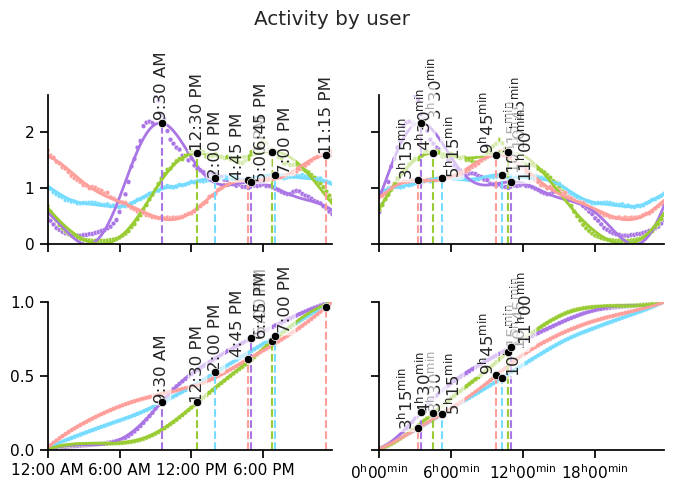

In [3]:
activity_result, ratio_result, disinf_activity_result = routine.by_user('all', save_plots=False);
activity_result.figure

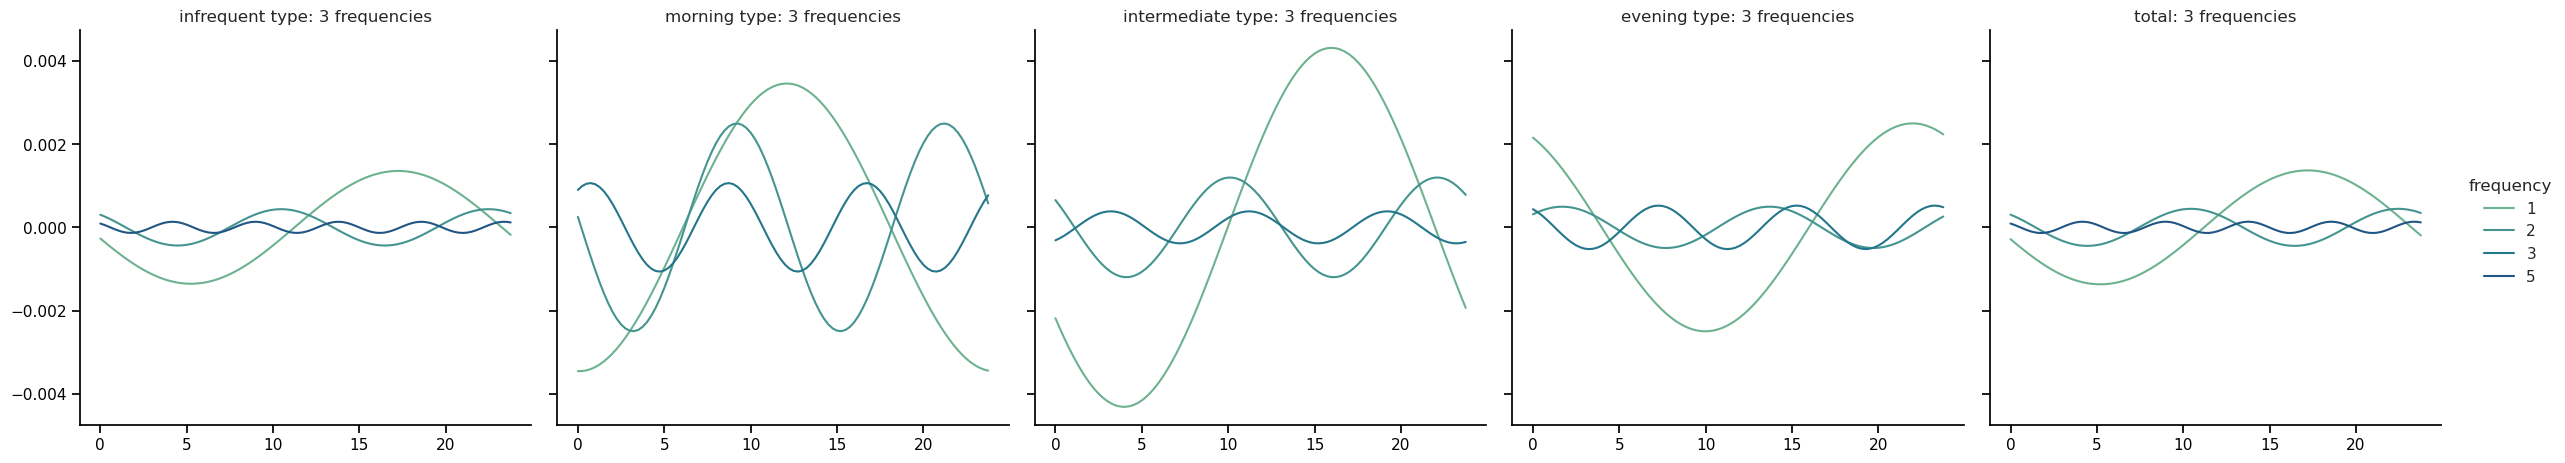

In [4]:
plot_sinewaves(activity_result.sinewaves, annotate_with=activity_result.frequencies);

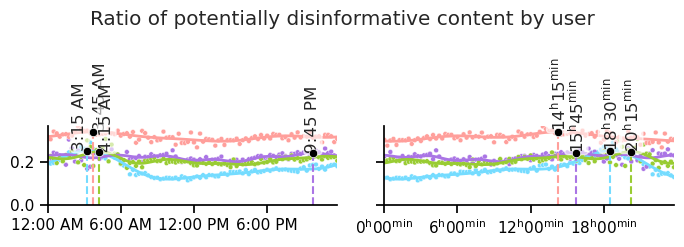

In [5]:
ratio_result.figure

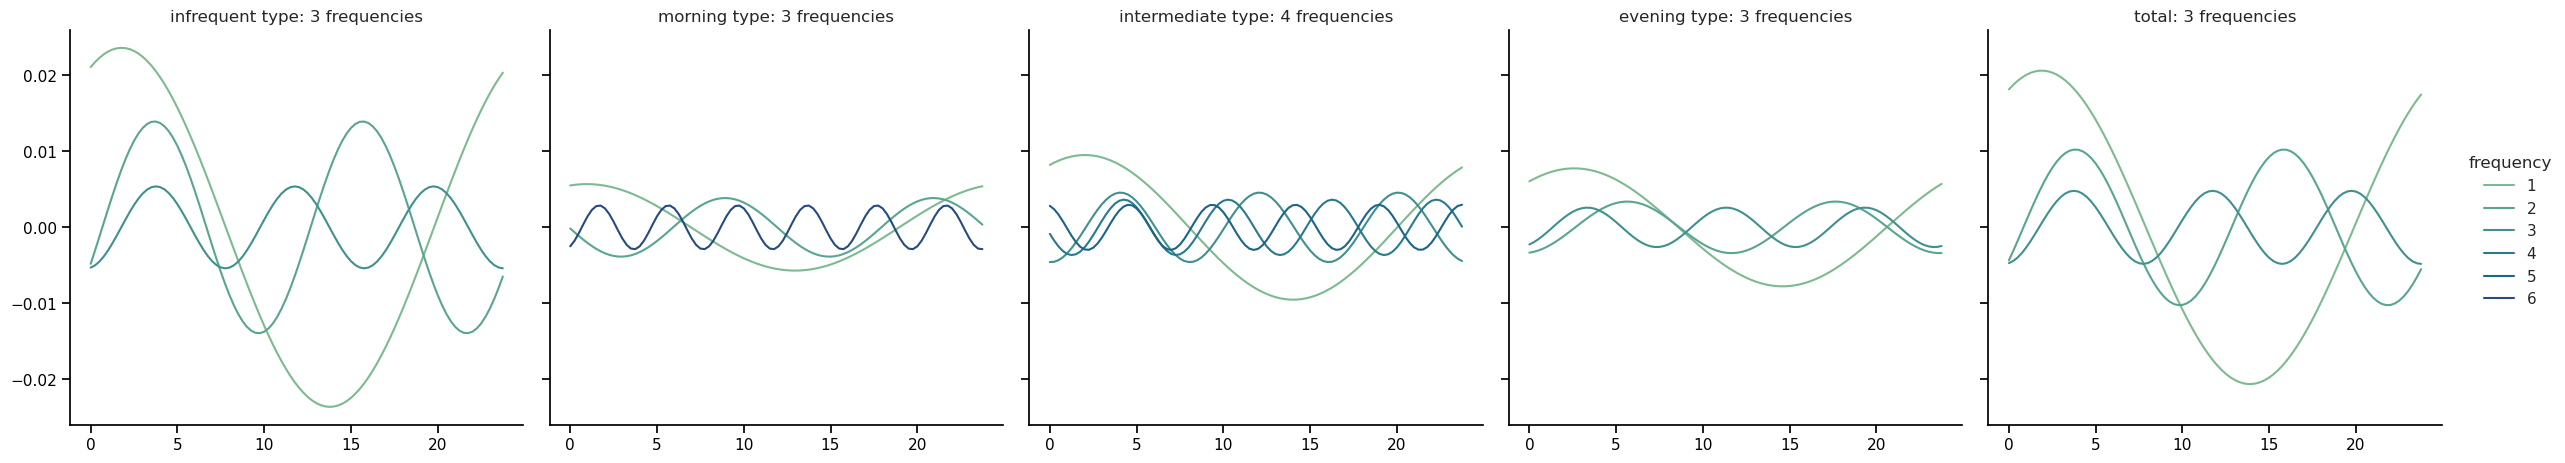

In [6]:
plot_sinewaves(ratio_result.sinewaves, annotate_with=ratio_result.frequencies);

In [7]:
ratio_result.signal.agg(('min', 'max'), axis=1)

,min,max
cluster,,
evening type,0.268195,0.365536
infrequent type,0.114927,0.290624
intermediate type,0.173034,0.307449
morning type,0.168463,0.304504
total,0.162679,0.294478


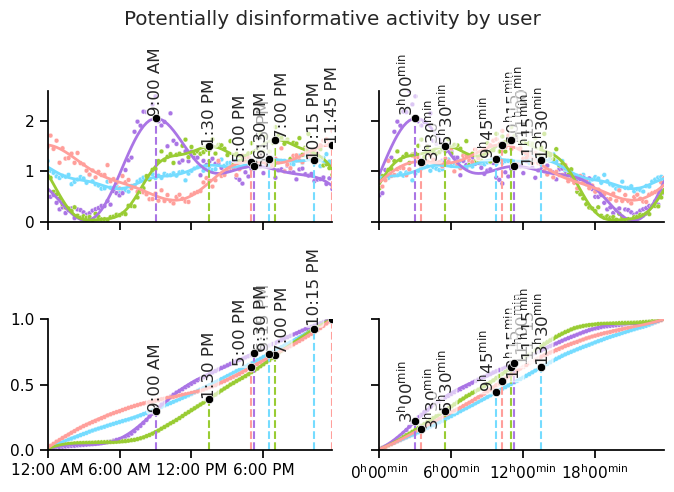

In [8]:
disinf_activity_result.figure

### Distances by activity curve features

If we assume that each chronotype follows similar behavioral patterns but with a time delay depending on their wake-up time, we should see that the curve of their susceptibility over time approaches that of other clusters when aligning the curves by similarity.

We have a few options for aligning by similarity:

We may align by what we estimate is the wake-up time. While we cannot infer the wake-up time per se, we can infer the time when users are usually not asleep, as they are active on Twitter. Therefore, we can estimate that the nadir of their activity is when they are fast asleep.
We consider the user to be asleep within the 8 consecutive hours that they are least active during the day.

Other options are
- the first inflection after the minimum activity (when the slope changes starts getting shallower)
- the first peak after the minimum activity
- the steepest ascent
- ...

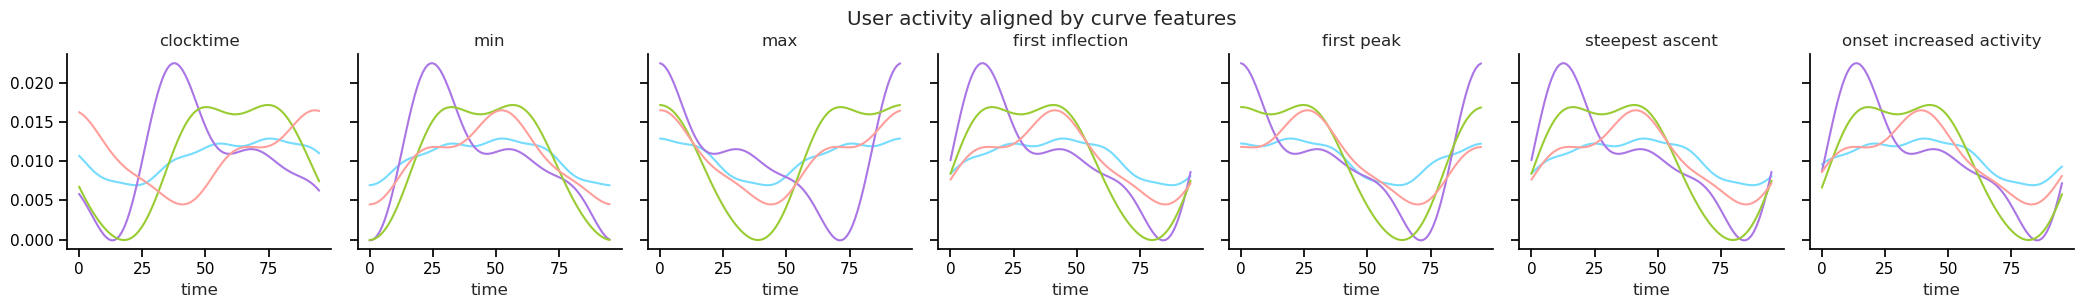

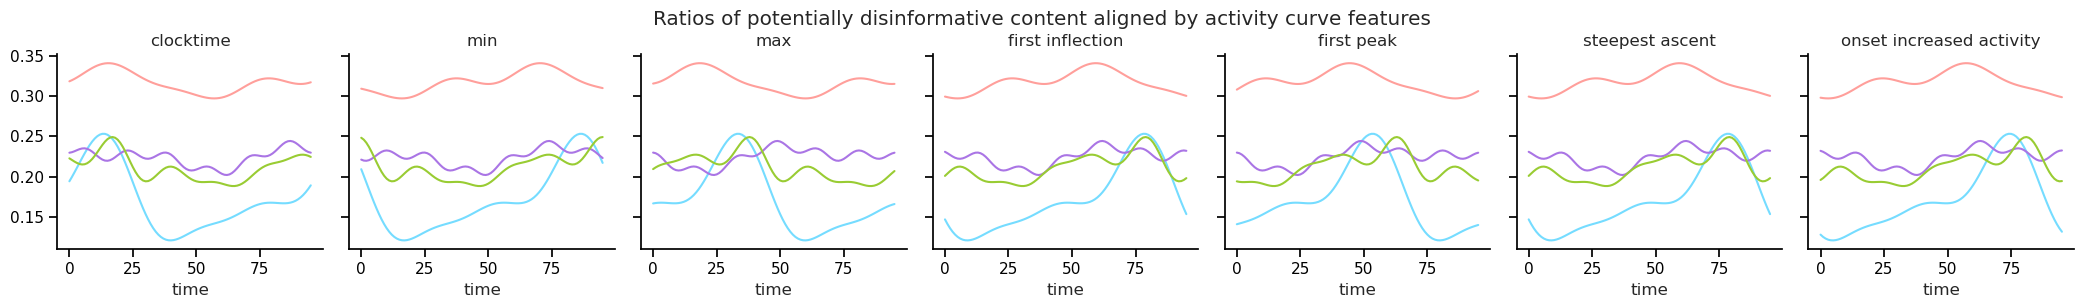

In [9]:
similarity_by_user = similarity_routine(activity_result.recomposed_signal, ratio_result.recomposed_signal, activity_result.increased_activity, index_slice=Clusters.order())

In [10]:
similarity_by_user.distance_activity_by_curve_features

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
clocktime,2.9e+01,8.6e-03,9.5e-02,3.3e+00,3.8e-01,2.0e-03,1.1e-05
min,2.5e+01,7.3e-03,7.4e-02,3.0e+00,3.0e-01,1.6e-03,7.9e-06
max,2.5e+01,7.6e-03,8.2e-02,3.0e+00,3.4e-01,1.7e-03,1.0e-05
first inflection,2.6e+01,7.7e-03,8.1e-02,3.1e+00,3.2e-01,1.7e-03,9.0e-06
first peak,2.2e+01,7.2e-03,7.4e-02,3.1e+00,3.0e-01,1.6e-03,8.2e-06
steepest ascent,2.6e+01,7.7e-03,8.1e-02,3.1e+00,3.2e-01,1.7e-03,9.0e-06
onset increased activity,2.7e+01,7.3e-03,7.5e-02,3.0e+00,3.0e-01,1.6e-03,7.9e-06


<p id="SupplTab4a">Supplementary Table 4(a)</p>

In [11]:
similarity_by_user.distance_ratio_by_activity_curve_features

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
clocktime,4.1e+01,1.3e-01,1.9e+00,4.0e+00,7.9e+00,4.1e-02,4.7e-03
min,2.6e+01,1.2e-01,2.0e+00,3.9e+00,7.9e+00,4.1e-02,4.8e-03
max,3.6e+01,1.3e-01,2.0e+00,4.0e+00,8.0e+00,4.1e-02,4.9e-03
first inflection,1.7e+01,1.3e-01,1.9e+00,4.0e+00,7.8e+00,4.1e-02,4.8e-03
first peak,2.8e+01,1.3e-01,1.9e+00,3.9e+00,7.9e+00,4.1e-02,4.8e-03
steepest ascent,1.7e+01,1.3e-01,1.9e+00,4.0e+00,7.8e+00,4.1e-02,4.8e-03
onset increased activity,1.7e+01,1.3e-01,1.9e+00,4.1e+00,7.8e+00,4.1e-02,4.8e-03


In [12]:
save_to_latex(
    config,
    similarity_by_user.distance_ratio_by_activity_curve_features,
    f'similarity_ratio_by_activity_fourier_all',
    r"Distance metrics for the ratio of potentially disinformative content when aligned by features of the cluster activity curves.",
    is_multi_index=False
)

## Activity, Ratio and potentially disinformative activity averaged over tweets in a cluster 

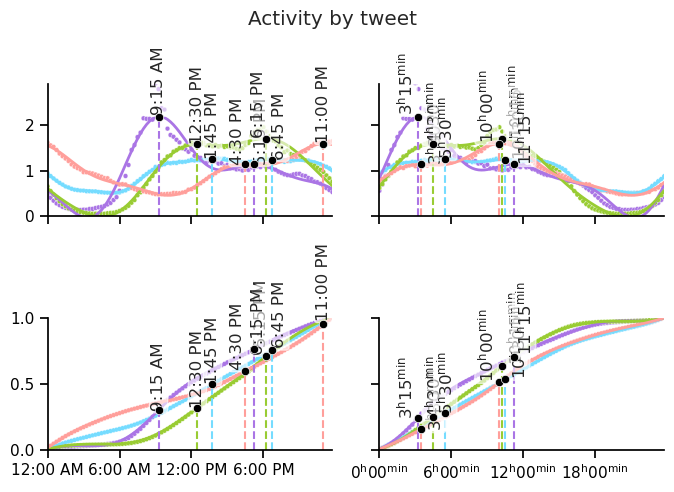

In [13]:
activity_result_by_tweet, ratio_result_by_tweet, disinf_activity_result_by_tweet = routine.by_tweet('all', save_plots=False);
activity_result_by_tweet.figure

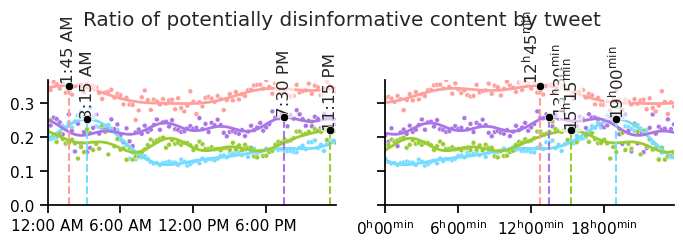

In [14]:
ratio_result_by_tweet.figure

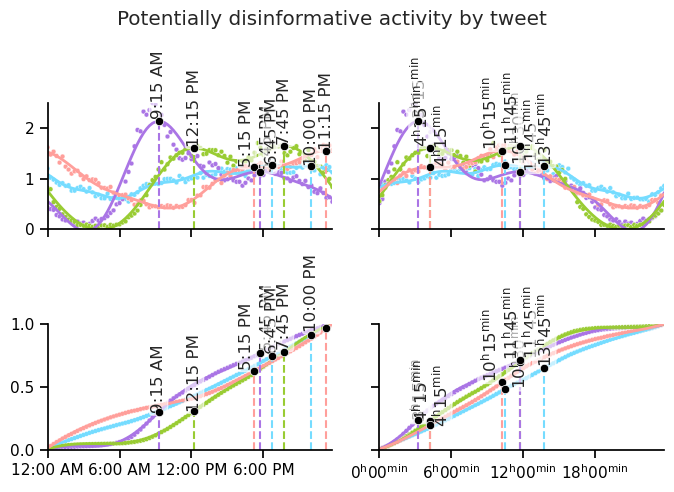

In [15]:
disinf_activity_result_by_tweet.figure

### Distances by activity curve features

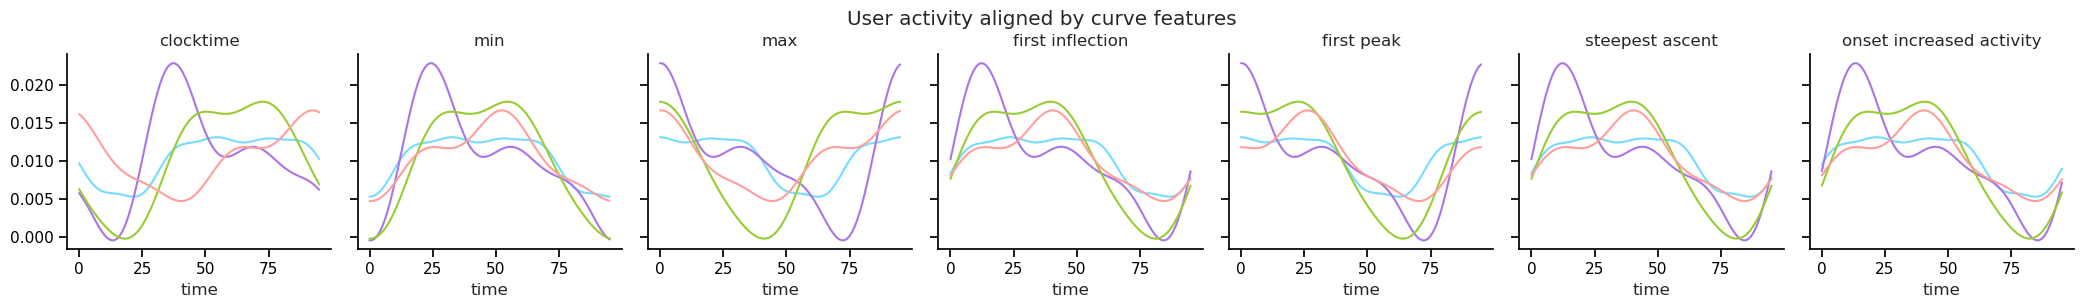

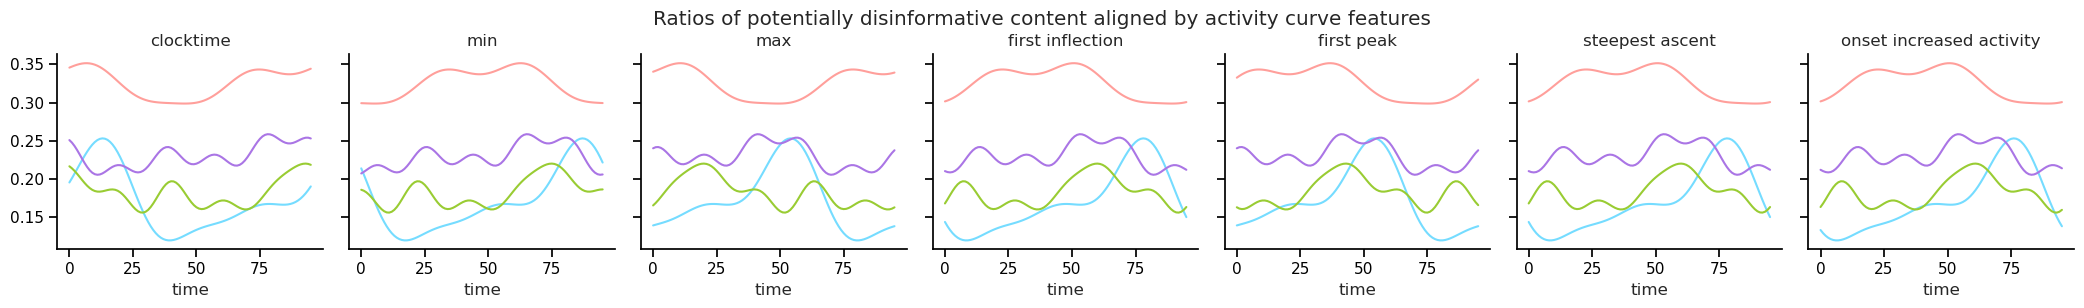

In [16]:
similarity_by_tweet = similarity_routine(activity_result_by_tweet.recomposed_signal, ratio_result_by_tweet.recomposed_signal, activity_result_by_tweet.increased_activity, index_slice=Clusters.order())

In [17]:
similarity_by_tweet.distance_activity_by_curve_features

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
clocktime,2.2e+01,8.3e-03,9.1e-02,3.3e+00,3.7e-01,1.9e-03,1.0e-05
min,1.7e+01,6.6e-03,6.4e-02,3.0e+00,2.6e-01,1.3e-03,6.0e-06
max,1.7e+01,9.1e-03,1.0e-01,3.3e+00,4.1e-01,2.1e-03,1.4e-05
first inflection,1.6e+01,6.7e-03,6.7e-02,3.0e+00,2.7e-01,1.4e-03,6.3e-06
first peak,1.6e+01,7.1e-03,7.2e-02,3.1e+00,2.9e-01,1.5e-03,7.5e-06
steepest ascent,1.6e+01,6.7e-03,6.7e-02,3.0e+00,2.7e-01,1.4e-03,6.3e-06
onset increased activity,2.0e+01,6.6e-03,6.4e-02,3.1e+00,2.6e-01,1.3e-03,5.8e-06


In [18]:
similarity_by_tweet.distance_ratio_by_activity_curve_features

,pcm,frechet,area_between_two_curves,curve_length_measure,dtw,mae,mse
clocktime,4.3e+01,1.3e-01,2.0e+00,4.3e+00,8.3e+00,4.3e-02,5.3e-03
min,2.6e+01,1.3e-01,2.0e+00,4.0e+00,8.0e+00,4.2e-02,5.5e-03
max,2.9e+01,1.4e-01,2.0e+00,4.2e+00,8.1e+00,4.2e-02,5.6e-03
first inflection,1.7e+01,1.3e-01,2.0e+00,4.3e+00,8.3e+00,4.3e-02,5.6e-03
first peak,2.8e+01,1.2e-01,1.9e+00,3.9e+00,7.8e+00,4.1e-02,5.2e-03
steepest ascent,1.7e+01,1.3e-01,2.0e+00,4.3e+00,8.3e+00,4.3e-02,5.6e-03
onset increased activity,1.6e+01,1.3e-01,2.0e+00,4.4e+00,8.1e+00,4.2e-02,5.5e-03


# Unverified

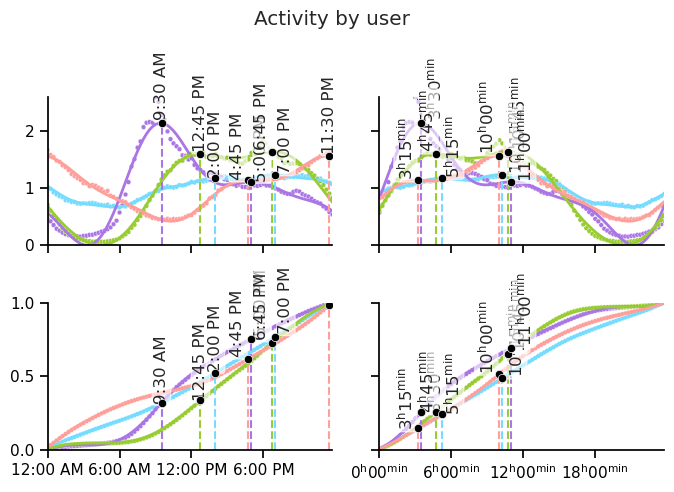

In [19]:
activity_result_unverified, ratio_result_unverified, disinf_activity_result_unverified = routine.by_user('unverified', save_plots=False);
activity_result_unverified.figure

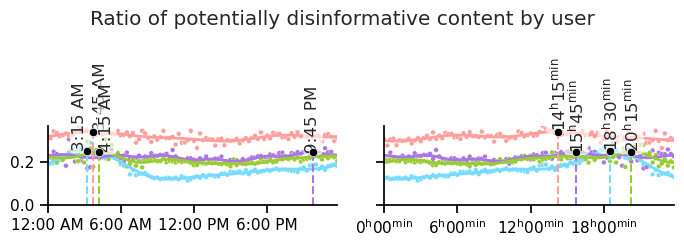

In [20]:
ratio_result_unverified.figure

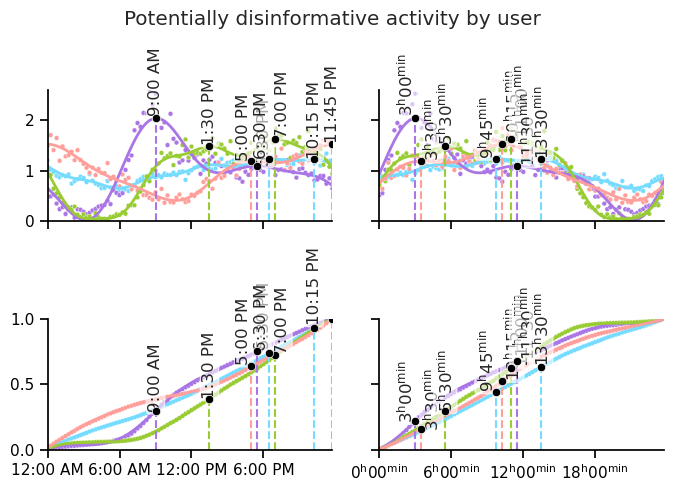

In [21]:
disinf_activity_result_unverified.figure

# Statistics

<p id="SupplTab3">Supplementary Table 2</p>

In [22]:
statsignals = {"activity": activity_result, "potentially disinformative content ratio": ratio_result, "potentially disinformative activity": disinf_activity_result}
activity_ratio_stats_style = style_extrema_stats_df(
    activity_result.increased_activity, 
    **statsignals,
    index_slice=pd.IndexSlice[statsignals.keys(), Clusters.order(), :]
)
save_to_latex(
    config, 
    activity_ratio_stats_style, 
    'activity_ratio_stats_all', 
    caption="Times of maximum and minimum of activity and of ratios of potentially disinformative content per cluster sorted by extremity.")

activity_ratio_stats_style

## Normal distribution

In [23]:
shapiro_df=pd.concat(
    [
        df.apply(shapiro, axis=1, result_type="expand") 
        for res in (activity_result, ratio_result)
        for df in (res.signal, res.recomposed_signal)
    ], 
    axis=1, keys=["activity (coarse)", "ratio (coarse)", "activity (smooth)", "ratio (smooth)"]
).rename(columns={0:'Statistic', 1: 'P-Value'})

In [24]:
shapiro_df_style = (shapiro_df
     .style
     .format('{:.3f}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "Statistic"]])
     .format('{:.1e}', subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]])
     .map(lambda v: 'font-weight: bold;' if (v <0.05)  else None, subset=pd.IndexSlice[:, pd.IndexSlice[:, "P-Value"]]))
shapiro_df_style

The data is not normally distributed.

## Distribution size of ratios of potentially disinformative content across clusters

<p id="Table1">Table 1</p>

In [25]:
mannwhitneyu_df_style = style_mwu_comparison_df(order=Clusters.order(), coarse=ratio_result.signal, smooth=ratio_result.recomposed_signal)

Evening types spread most potentially machinated content,  infrequent types the least.

## Bimodality

<p id="SupplTab4">Supplementary Table 3:</p>

In [26]:
dip_df_style = style_dip_df(activity_result.increased_activity, order=Clusters.order(), coarse=activity_result.signal, smooth=activity_result.recomposed_signal)
save_to_latex(config, dip_df_style, 'dip_bimodality', caption="Dip-test for unimodality of user activity curves.")
dip_df_style